# Data generation for Navier Stokes

The Navier Stokes equation is given by

$$
\begin{align}
\partial_t w(x,t) + u(x,t) \cdot \nabla w(x,t) &= \nu \Delta w(x,t) + f(x)\\
\nabla \cdot u(x,t) &= 0\\
w(x,0) &= w_0(x)
\end{align}
$$

where $w(x,t)$ is the velocity field, $u(x,t)$ is the vortex field, $\nu$ is the viscosity, and $f(x)$ is the forcing term.

## Libraries


In [4]:
# PyTorch
import torch

# Math
import math

# Scipy
import scipy.io

# Timeit for measuring execution time
from timeit import default_timer

# Matplotlib
import matplotlib.pyplot as plt

# Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print GPUs device name
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print("GPU",i,":",torch.cuda.get_device_name(i))

GPU 0 : NVIDIA GeForce RTX 3050 Laptop GPU


## Function to create random initial conditions

In [11]:
class GaussianRF(object):

    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic", device=None):

        self.dim = dim
        self.device = device

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size//2

        if dim == 1:
            k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

            self.sqrt_eig = size*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0

        elif dim == 2:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,1)

            k_x = wavenumers.transpose(0,1)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0

        elif dim == 3:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,size,1)

            k_x = wavenumers.transpose(1,2)
            k_y = wavenumers
            k_z = wavenumers.transpose(0,2)

            self.sqrt_eig = (size**3)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0,0] = 0.0

        self.size = []
        for j in range(self.dim):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, N):

        coeff = torch.randn(N, *self.size, dtype=torch.cfloat, device=self.device)
        coeff = self.sqrt_eig * coeff

        return torch.fft.ifftn(coeff, dim=list(range(-1, -self.dim - 1, -1))).real

In [12]:
gauss = GaussianRF(dim=2, size=32, alpha=2, tau=3, sigma=1, device=device)

In [14]:
# Generate a sample
sample = gauss.sample(1)

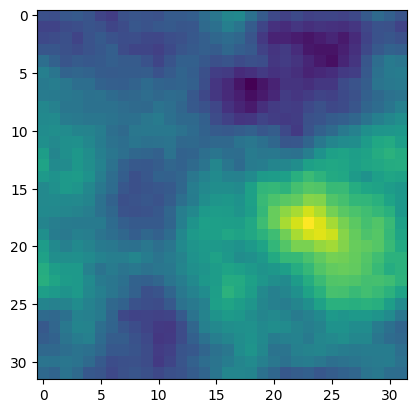

In [15]:
# Plot the sample
plt.imshow(sample[0].cpu().numpy(), cmap='viridis')
plt.show()

## Function to solve Navier Stokes

In [ ]:
# Function to solve Navier-Stokes equation in 2D
def navier_stokes_2d(w0, f, visc, T, delta_t=1e-4, record_steps=1):

    # Grid size - it must be power of 2
    N = w0.size()[-1]

    # Max wavenumber
    k_max = math.floor(N/2.0)

    # Total number of steps
    steps = math.ceil(T/delta_t)

    # Initial vortex field in Fourier space
    w_h = torch.fft.rfft2(w0)

    # Forcing field in Fourier space
    f_h = torch.fft.rfft2(f)

    # If the same forcing for the whole batch
    if len(f_h.size()) < len(w_h.size()):
        f_h = torch.unsqueeze(f_h, 0)

    # Save the solution every certain number of steps
    record_time = math.floor(steps/record_steps)

    # Wave numbers in y-direction
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w0.device), torch.arange(start=-k_max, end=0, step=1, device=w0.device)), 0).repeat(N,1)
    
    # Wave numbers in x-direction
    k_x = k_y.transpose(0,1)

    # Remove redundant modes
    k_x = k_x[..., :k_max + 1]
    k_y = k_y[..., :k_max + 1]

    # Negative of the Laplacian in Fourier space
    lap = 4*(math.pi**2)*(k_x**2 + k_y**2)
    lap[0,0] = 1.0
    
    # Dealiasing mask
    dealias = torch.unsqueeze(torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float(), 0)

    # Save the solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=w0.device)
    sol_t = torch.zeros(record_steps, device=w0.device)

    #Record counter
    c = 0
    
    #Physical time
    t = 0.0
    for j in range(steps):
        
        #Stream function in Fourier space: solve Poisson equation
        psi_h = w_h / lap

        #Velocity field in x-direction = psi_y
        q = 2. * math.pi * k_y * 1j * psi_h
        q = torch.fft.irfft2(q, s=(N, N))

        #Velocity field in y-direction = -psi_x
        v = -2. * math.pi * k_x * 1j * psi_h
        v = torch.fft.irfft2(v, s=(N, N))

        #Partial x of vorticity
        w_x = 2. * math.pi * k_x * 1j * w_h
        w_x = torch.fft.irfft2(w_x, s=(N, N))

        #Partial y of vorticity
        w_y = 2. * math.pi * k_y * 1j * w_h
        w_y = torch.fft.irfft2(w_y, s=(N, N))

        #Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = torch.fft.rfft2(q*w_x + v*w_y)

        #Dealias
        F_h = dealias* F_h

        #Crank-Nicolson update
        w_h = (-delta_t*F_h + delta_t*f_h + (1.0 - 0.5*delta_t*visc*lap)*w_h)/(1.0 + 0.5*delta_t*visc*lap)

        #Update real time (used only for recording)
        t += delta_t

        if (j+1) % record_time == 0:
            #Solution in physical space
            w = torch.fft.irfft2(w_h, s=(N, N))

            #Record solution and time
            sol[...,c] = w
            sol_t[c] = t

            c += 1

    return sol, sol_t

## Get data and save to MATLAB file

We are going to generate data for the following parameters:

- $\nu =1\times 10^{-3}$
- $f(x, y) = 0.1 \sin(2\pi (x+y)) \cos(2\pi (x+y))$

In [ ]:
#Resolution
s = 256

#Number of solutions to generate
N = 20

#Set up 2d GRF with covariance parameters
GRF = GaussianRF(2, s, alpha=2.5, tau=7, device=device)

# Time grid
t = torch.linspace(0, 1, s+1, device=device)
t = t[0:-1]

# Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
X,Y = torch.meshgrid(t, t, indexing='ij')
f = 0.1*(torch.sin(2*math.pi*(X + Y)) + torch.cos(2*math.pi*(X + Y)))

#Number of snapshots from solution
record_steps = 200

#Inputs
a = torch.zeros(N, s, s)
#Solutions
u = torch.zeros(N, s, s, record_steps)

#Solve equations in batches (order of magnitude speed-up)

#Batch size
bsize = 20

c = 0
t0 = default_timer()
for j in range(N//bsize):

    #Sample random feilds
    w0 = GRF.sample(bsize)

    #Solve NS
    sol, sol_t = navier_stokes_2d(w0, f, 1e-3, 50.0, 1e-4, record_steps)

    a[c:(c+bsize),...] = w0
    u[c:(c+bsize),...] = sol

    c += bsize
    t1 = default_timer()
    print(j, c, t1-t0)

scipy.io.savemat('ns_data.mat', mdict={'a': a.cpu().numpy(), 'u': u.cpu().numpy(), 't': sol_t.cpu().numpy()})